In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
from shapely.ops import unary_union
import os
import matplotlib.font_manager as fm

# Try to set up Chinese font support
try:
    # For Mac
    font_path = '/System/Library/Fonts/PingFang.ttc'
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        # For Windows
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"Warning: Font setup issue - {e}")

# Define Taiwan regions by county
TAIWAN_REGIONS = {
    'north': ['臺北市', '台北市', '新北市', '基隆市', '桃園市', '新竹市', '新竹縣', '宜蘭縣'],
    'central': ['苗栗縣', '臺中市', '台中市', '彰化縣', '南投縣', '雲林縣'],
    'south': ['嘉義市', '嘉義縣', '臺南市', '台南市', '高雄市', '屏東縣', '澎湖縣'],
    'east': ['花蓮縣', '臺東縣', '台東縣']
}

# Function to load shapefile
def load_shapefile(shp_path):
    """Load shapefile and return shapefile.Reader object"""
    import shapefile as shp
    return shp.Reader(shp_path)

# Function to process sensor data
def process_sensor_data(sensor_df):
    """
    Process sensor data to calculate:
    1. Number of unique stations per township
    2. Average flooding depth per township
    
    Parameters:
    sensor_df: DataFrame with sensor data
    
    Returns:
    tuple: (station_count_dict, avg_depth_dict)
    """
    # Count unique stations per township
    station_count = sensor_df.groupby('TOWNNAME')['station_id'].nunique()
    station_count_dict = station_count.to_dict()
    
    # Calculate average depth per township
    avg_depth = sensor_df.groupby('TOWNNAME')['value'].mean()
    avg_depth_dict = avg_depth.to_dict()
    
    # Print some stats
    print(f"Processed {len(sensor_df)} flood sensor readings")
    print(f"Found data for {len(station_count_dict)} townships")
    print("\nTop 5 townships by station count:")
    print(station_count.sort_values(ascending=False).head(5))
    print("\nTop 5 townships by average flooding depth:")
    print(avg_depth.sort_values(ascending=False).head(5))
    
    return station_count_dict, avg_depth_dict

# Function to create heatmap
def plot_township_heatmap(sf, data_dict, metric_name, region=None, 
                         x_lim=(120, 122), y_lim=(21.8, 25.3),
                         figsize=(15, 20), cmap='YlOrRd', title=None,
                         output_path=None):
    """
    Plot township heatmap with county labels
    
    Parameters:
    sf: shapefile Reader object
    data_dict: Dictionary with township data {township_name: value}
    metric_name: Name of the metric (for colorbar)
    region: Optional region filter ('north', 'central', 'south', 'east')
    x_lim, y_lim: Map boundaries
    figsize: Figure size
    cmap: Colormap
    title: Optional custom title
    output_path: Optional path to save the figure
    
    Returns:
    Figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set map boundaries
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    # Get field indices
    fields = sf.fields[1:]
    field_names = [field[0] for field in fields]
    county_idx = field_names.index('COUNTYNAME')
    
    # Find township field
    town_idx = None
    for possible_name in ['TOWNNAME', 'TOWNSHIPNAME', 'TOWNSHIP']:
        if possible_name in field_names:
            town_idx = field_names.index(possible_name)
            break
    
    # Get counties for the region if specified
    region_counties = None
    if region:
        region_counties = TAIWAN_REGIONS.get(region.lower(), [])
    
    # Prepare data structures
    township_polygons = {}  # {township_name: shapely_polygon}
    township_values = {}    # {township_name: value}
    county_polygons = {}    # {county_name: [shapely_polygons]}
    township_to_county = {} # {township_name: county_name}
    
    # Process shapes
    for shape in sf.shapeRecords():
        county_name = shape.record[county_idx]
        
        # Skip if not in the specified region
        if region_counties and county_name not in region_counties:
            continue
            
        # Get township name if available
        town_name = None
        if town_idx is not None:
            town_name = shape.record[town_idx]
        
        # Get coordinates
        x = [p[0] for p in shape.shape.points]
        y = [p[1] for p in shape.shape.points]
        
        # Skip if outside our area
        x0, y0 = np.mean(x), np.mean(y)
        if not (x_lim[0] <= x0 <= x_lim[1] and y_lim[0] <= y0 <= y_lim[1]):
            continue
            
        # Create polygon
        try:
            points = list(zip(x, y))
            poly = Polygon(points)
            if not poly.is_valid:
                poly = poly.buffer(0)
                
            # Store county polygon
            county_polygons.setdefault(county_name, []).append(poly)
            
            # Store township data if available
            if town_name and not poly.is_empty:
                township_polygons[town_name] = poly
                township_to_county[town_name] = county_name
                
                # Store value if this township has data
                if town_name in data_dict:
                    township_values[town_name] = data_dict[town_name]
        except Exception as e:
            print(f"Error processing shape: {e}")
    
    # Prepare colormap
    if township_values:
        vmin = min(township_values.values())
        vmax = max(township_values.values())
    else:
        vmin, vmax = 0, 1
    
    norm = plt.Normalize(vmin, vmax)
    color_mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Draw township boundaries (light gray)
    for town_name, poly in township_polygons.items():
        if poly.geom_type == 'Polygon':
            x, y = poly.exterior.xy
            ax.plot(x, y, color='lightgray', linewidth=0.5, zorder=1)
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly.geoms:
                x, y = subpoly.exterior.xy
                ax.plot(x, y, color='lightgray', linewidth=0.5, zorder=1)
    
    # Fill townships with data
    for town_name, poly in township_polygons.items():
        if town_name in township_values:
            value = township_values[town_name]
            color = color_mapper.to_rgba(value)
            
            if poly.geom_type == 'Polygon':
                x, y = poly.exterior.xy
                ax.fill(x, y, color=color, alpha=0.7, zorder=2)
            elif poly.geom_type == 'MultiPolygon':
                for subpoly in poly.geoms:
                    x, y = subpoly.exterior.xy
                    ax.fill(x, y, color=color, alpha=0.7, zorder=2)
    
    # Draw county boundaries (black)
    county_centroids = {}  # For county labels
    for county, polys in county_polygons.items():
        union_poly = unary_union(polys)
        if union_poly.is_empty:
            continue
            
        # Store centroid
        county_centroids[county] = union_poly.centroid
        
        # Draw boundary
        if union_poly.geom_type == 'Polygon':
            x, y = union_poly.exterior.xy
            ax.plot(x, y, color='black', linewidth=1.5, zorder=4)
        elif union_poly.geom_type == 'MultiPolygon':
            for subpoly in union_poly.geoms:
                x, y = subpoly.exterior.xy
                ax.plot(x, y, color='black', linewidth=1.5, zorder=4)
    
    # Add township labels with values
    for town_name, poly in township_polygons.items():
        if town_name in township_values:
            value = township_values[town_name]
            centroid = poly.centroid
            
            # Format the value
            if isinstance(value, float):
                if value > 100:  # Large values
                    formatted_value = f"{value:.0f}"
                elif value > 10:  # Medium values
                    formatted_value = f"{value:.1f}"
                else:  # Small values
                    formatted_value = f"{value:.2f}"
            else:
                formatted_value = f"{value}"
            
            label = f"{town_name}\n{formatted_value}"
            
            # Determine text color based on background brightness
            color_value = color_mapper.to_rgba(value)
            brightness = 0.299*color_value[0] + 0.587*color_value[1] + 0.114*color_value[2]
            text_color = 'black' if brightness > 0.5 else 'white'
            
            ax.text(centroid.x, centroid.y, label,
                   fontsize=8, ha='center', va='center',
                   color=text_color, zorder=5, fontweight='bold')
    
    # Add county labels with arrows
    # Group counties by position
    map_width = x_lim[1] - x_lim[0]
    map_height = y_lim[1] - y_lim[0]
    center_x = (x_lim[0] + x_lim[1]) / 2
    center_y = (y_lim[0] + y_lim[1]) / 2
    
    # Group counties by position
    west_counties = []
    east_counties = []
    north_counties = []
    south_counties = []
    
    for county, centroid in county_centroids.items():
        # Determine closest edge
        dist_to_left = centroid.x - x_lim[0]
        dist_to_right = x_lim[1] - centroid.x
        dist_to_bottom = centroid.y - y_lim[0]
        dist_to_top = y_lim[1] - centroid.y
        
        min_dist = min(dist_to_left, dist_to_right, dist_to_bottom, dist_to_top)
        
        if min_dist == dist_to_left:
            west_counties.append((county, centroid))
        elif min_dist == dist_to_right:
            east_counties.append((county, centroid))
        elif min_dist == dist_to_bottom:
            south_counties.append((county, centroid))
        elif min_dist == dist_to_top:
            north_counties.append((county, centroid))
    
    # Sort by position
    west_counties.sort(key=lambda x: x[1].y, reverse=True)
    east_counties.sort(key=lambda x: x[1].y, reverse=True)
    north_counties.sort(key=lambda x: x[1].x)
    south_counties.sort(key=lambda x: x[1].x)
    
    # Arrow style
    arrow_style = dict(arrowstyle="->", color='black', linewidth=1.5, connectionstyle="arc3,rad=0.2")
    text_style = dict(fontsize=12, fontweight='bold', color='black', 
                     bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    
    # Add county labels
    # West side
    for i, (county, centroid) in enumerate(west_counties):
        label_x = x_lim[0] + map_width * 0.05
        label_y = y_lim[0] + map_height * (0.9 - i * 0.05)
        
        ax.annotate(county, xy=(centroid.x, centroid.y), xytext=(label_x, label_y),
                   arrowprops=arrow_style, zorder=6, **text_style)
    
    # East side
    for i, (county, centroid) in enumerate(east_counties):
        label_x = x_lim[1] - map_width * 0.05
        label_y = y_lim[0] + map_height * (0.9 - i * 0.05)
        
        ax.annotate(county, xy=(centroid.x, centroid.y), xytext=(label_x, label_y),
                   arrowprops=arrow_style, zorder=6, **text_style)
    
    # North side
    for i, (county, centroid) in enumerate(north_counties):
        label_x = x_lim[0] + map_width * (0.1 + i * 0.1)
        label_y = y_lim[1] - map_height * 0.05
        
        ax.annotate(county, xy=(centroid.x, centroid.y), xytext=(label_x, label_y),
                   arrowprops=arrow_style, zorder=6, **text_style)
    
    # South side
    for i, (county, centroid) in enumerate(south_counties):
        label_x = x_lim[0] + map_width * (0.1 + i * 0.1)
        label_y = y_lim[0] + map_height * 0.05
        
        ax.annotate(county, xy=(centroid.x, centroid.y), xytext=(label_x, label_y),
                   arrowprops=arrow_style, zorder=6, **text_style)
    
    # Add grid
    grid_step = 0.1
    x_ticks = np.arange(np.floor(x_lim[0] * 10) / 10, np.ceil(x_lim[1] * 10) / 10 + grid_step, grid_step)
    y_ticks = np.arange(np.floor(y_lim[0] * 10) / 10, np.ceil(y_lim[1] * 10) / 10 + grid_step, grid_step)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Format axis labels
    def format_degree(value, pos):
        return f'{value:.1f}°'
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_degree))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_degree))
    
    # Add colorbar
    cbar = plt.colorbar(color_mapper, ax=ax, pad=0.01)
    cbar.set_label(metric_name)
    
    # Set title
    region_name = ""
    if region:
        region_name_map = {'north': '北部', 'central': '中部', 'south': '南部', 'east': '東部'}
        region_name = region_name_map.get(region, region)
    
    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title(f"{region_name}鄉鎮市 {metric_name} 熱點圖", fontsize=16)
    
    plt.xlabel("經度", fontsize=12)
    plt.ylabel("緯度", fontsize=12)
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved map to {output_path}")
    
    return fig, ax

# Function to create all heatmaps
def create_all_heatmaps(sf, year, output_dir=None):
    """
    Create all heatmaps for Taiwan and its regions
    
    Parameters:
    sf: shapefile Reader object
    year: DataFrame with sensor data
    output_dir: Directory to save output files
    """
    
    dataset_path = "/Users/andy/Box Sync/Andy/Project/Intern/Formosa/dataset"
    sensor_df = pd.read_csv(os.path.join(dataset_path, 'sensor' ,f'flood_data_{year}_merged_filled.csv'))
    
    # Process sensor data
    station_count_dict, avg_depth_dict = process_sensor_data(sensor_df)
    
    # Create output directory if needed
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Taiwan-wide heatmaps
    # 1. Station count heatmap
    plot_township_heatmap(
        sf, 
        station_count_dict, 
        "淹水感測站數量",
        cmap='YlGnBu',
        title="全台灣鄉鎮市淹水感測站數量熱點圖",
        output_path=os.path.join(output_dir, "taiwan_station_count.png") if output_dir else None
    )
    
    # 2. Average depth heatmap
    plot_township_heatmap(
        sf, 
        avg_depth_dict, 
        "平均淹水深度 (cm)",
        cmap='YlOrRd',
        title="全台灣鄉鎮市平均淹水深度熱點圖",
        output_path=os.path.join(output_dir, "taiwan_avg_depth.png") if output_dir else None
    )


Processed 62296 flood sensor readings
Found data for 112 townships

Top 5 townships by station count:
TOWNNAME
口湖鄉    19
東石鄉    11
太保市    11
元長鄉    10
六腳鄉     9
Name: station_id, dtype: int64

Top 5 townships by average flooding depth:
TOWNNAME
新營區    233.296150
虎尾鎮    227.924336
東石鄉    206.406698
新港鄉    197.748856
民雄鄉    189.600365
Name: value, dtype: float64
Saved map to output_maps/taiwan_station_count.png
Saved map to output_maps/taiwan_avg_depth.png


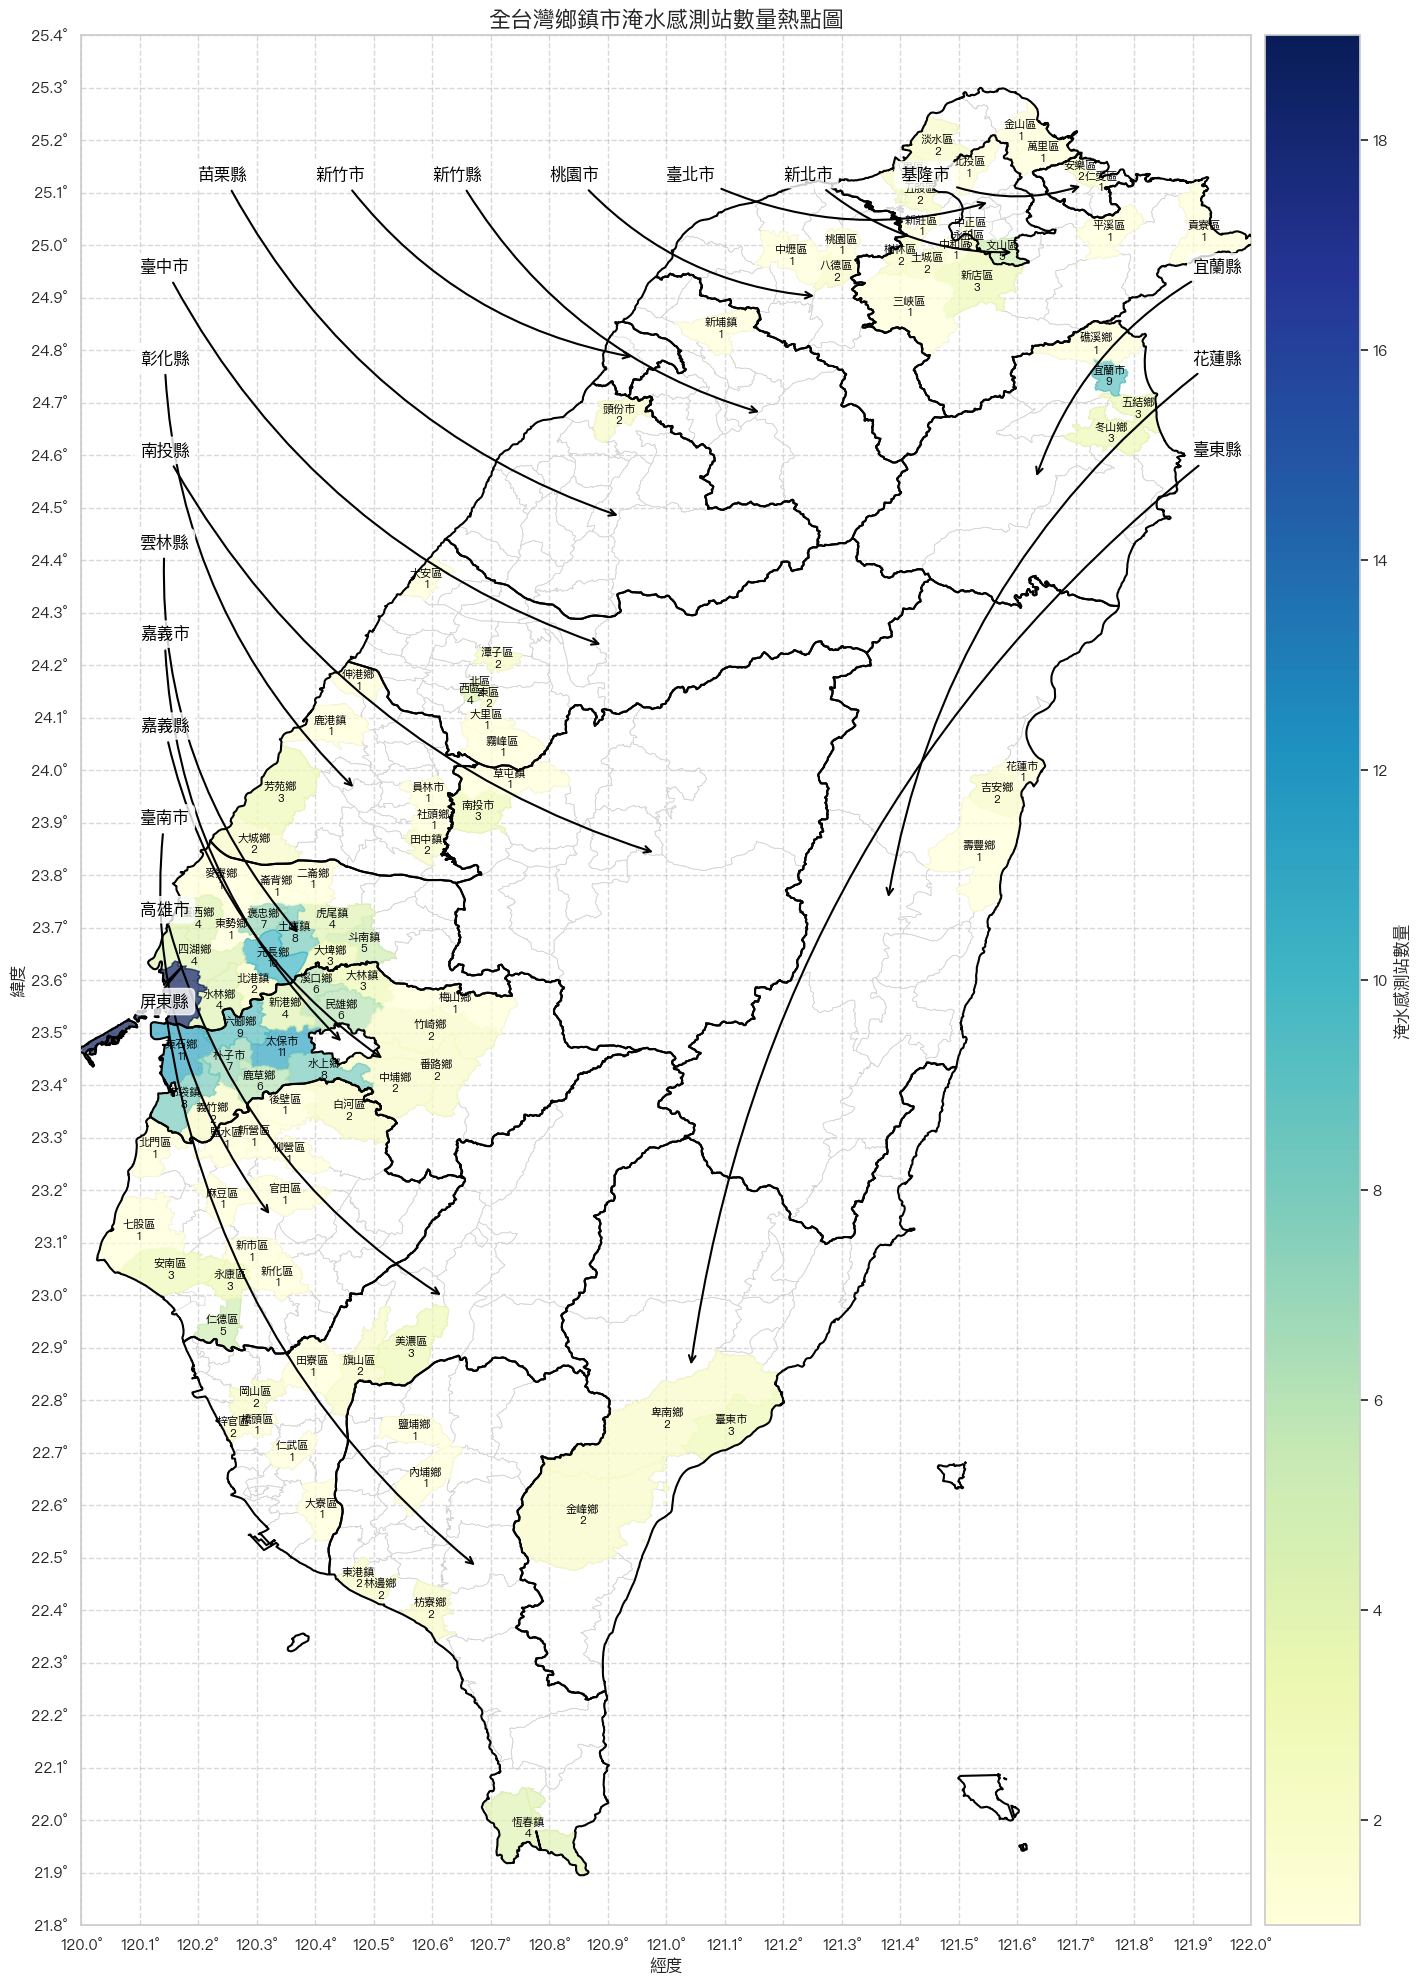

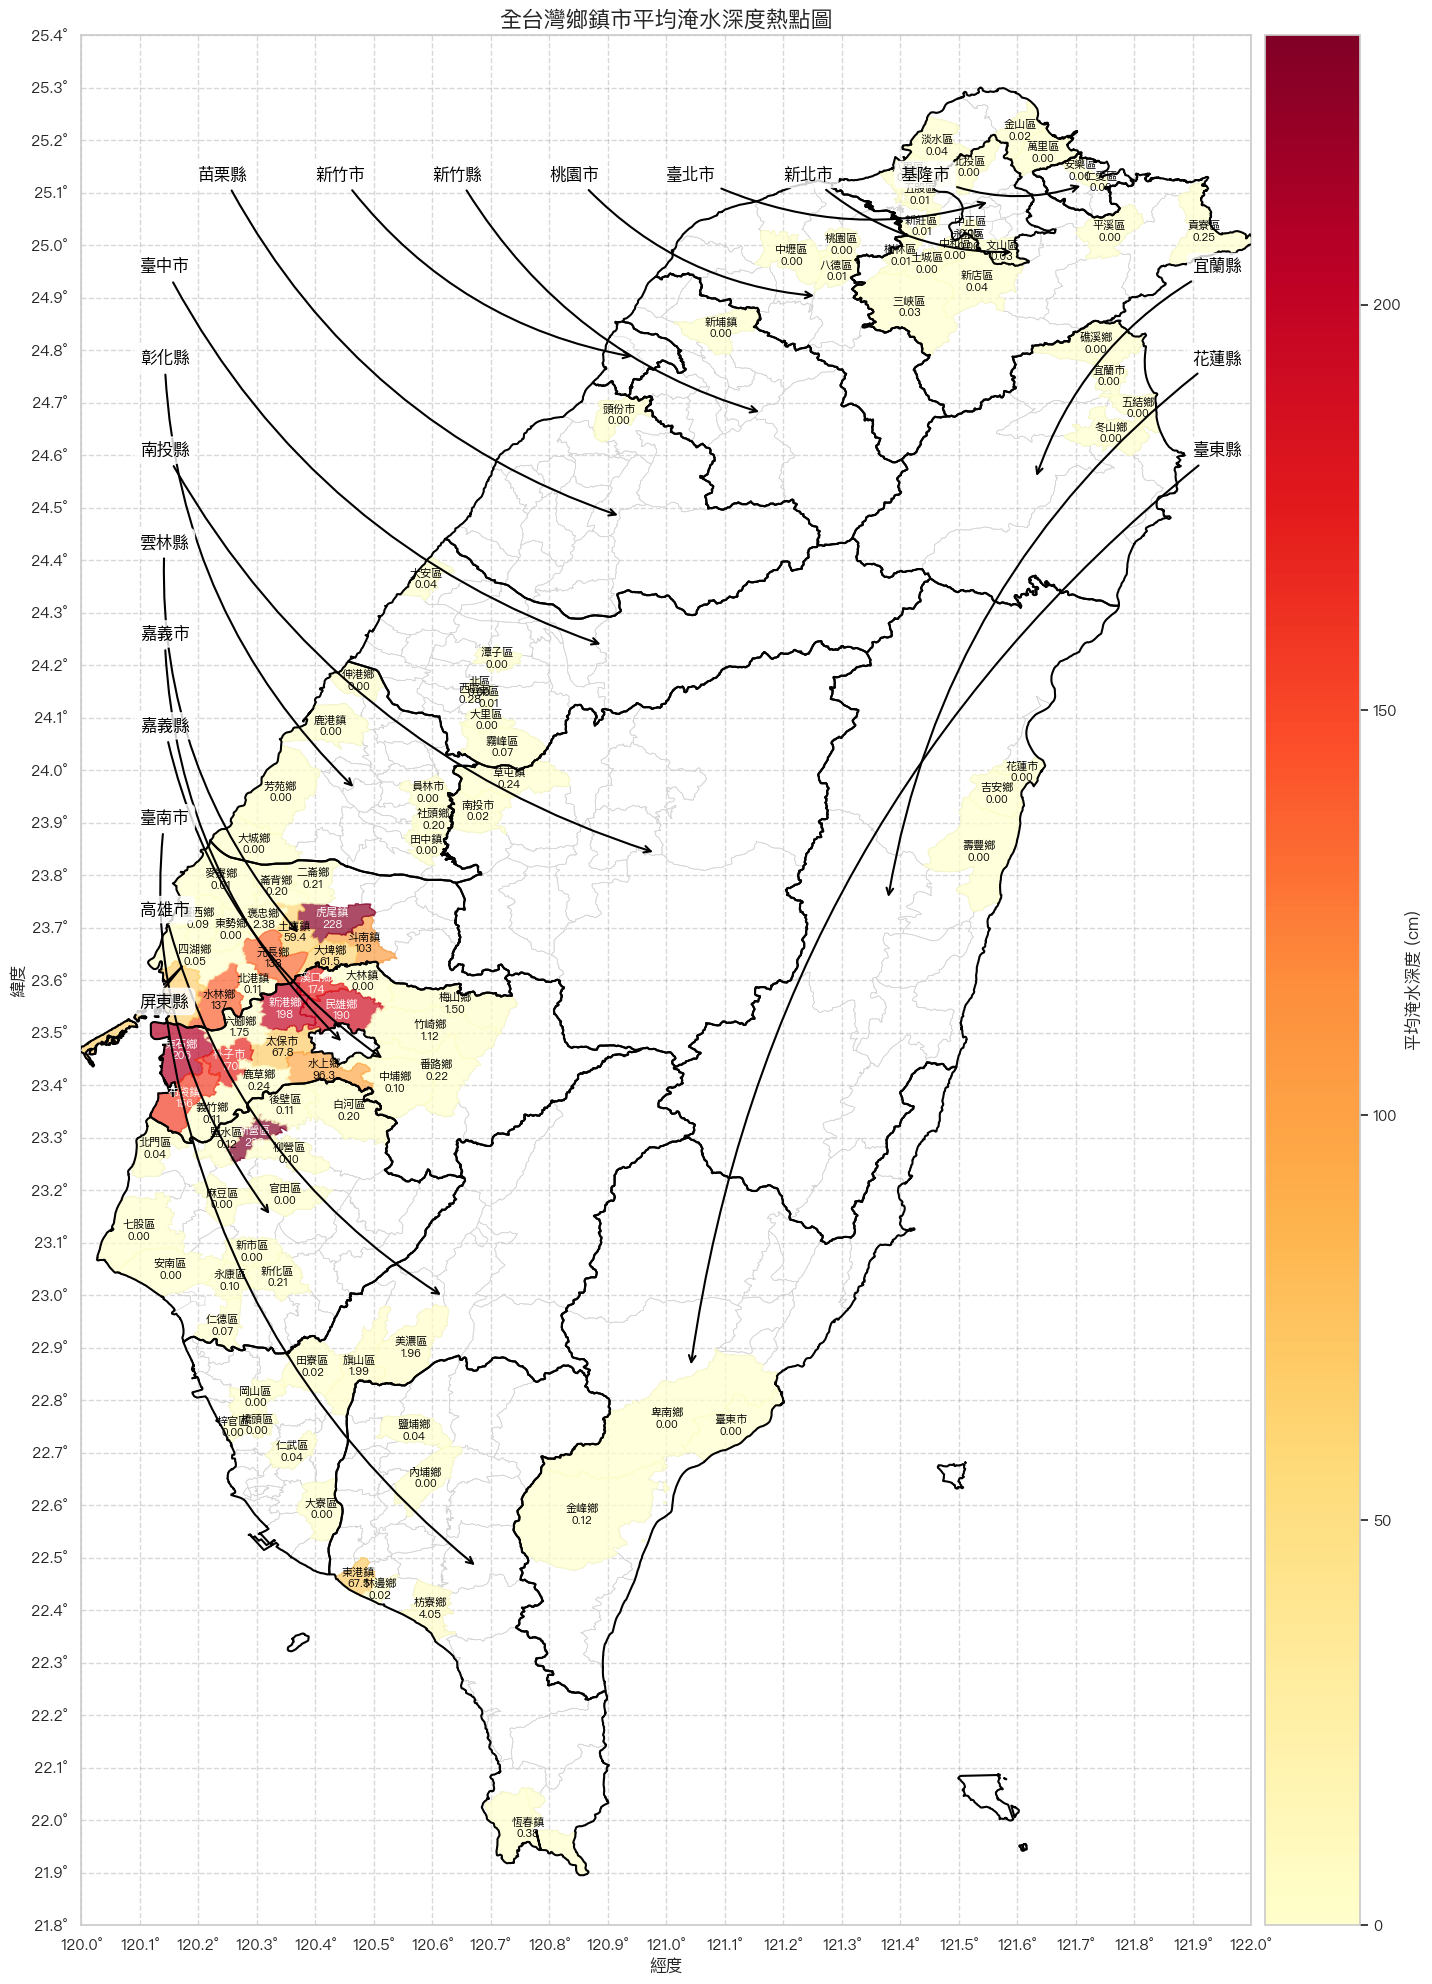

In [11]:
# Update these paths to your actual files

dataset_path = "/Users/andy/Box Sync/Andy/Project/Intern/Formosa/dataset"

shp_path = os.path.join(dataset_path,'鄉鎮市區界線(TWD97經緯度)/TOWN_MOI_1120317.shp')
sensor_data_path = os.path.join(dataset_path,'sensor' ,'flood_data_2019_merged_filled.csv')
output_dir = "output_maps"

# Load shapefile
sf = load_shapefile(shp_path)

# Create all heatmaps
create_all_heatmaps(sf, 2019, output_dir)

讀取地圖檔案...
讀取淹水感測資料...
計算鄉鎮市統計資料...
Processed 62296 flood sensor readings
Found data for 112 townships

Top 5 townships by station count:
TOWNNAME
口湖鄉    19
東石鄉    11
太保市    11
元長鄉    10
六腳鄉     9
Name: station_id, dtype: int64

Top 5 townships by average flooding depth:
TOWNNAME
新營區    233.296150
虎尾鎮    227.924336
東石鄉    206.406698
新港鄉    197.748856
民雄鄉    189.600365
Name: value, dtype: float64
分析雨季和乾季的差異...
Saved map to output_maps/rainy_season_depth.png
Saved map to output_maps/dry_season_depth.png
分析完成！所有地圖已儲存到 output_maps


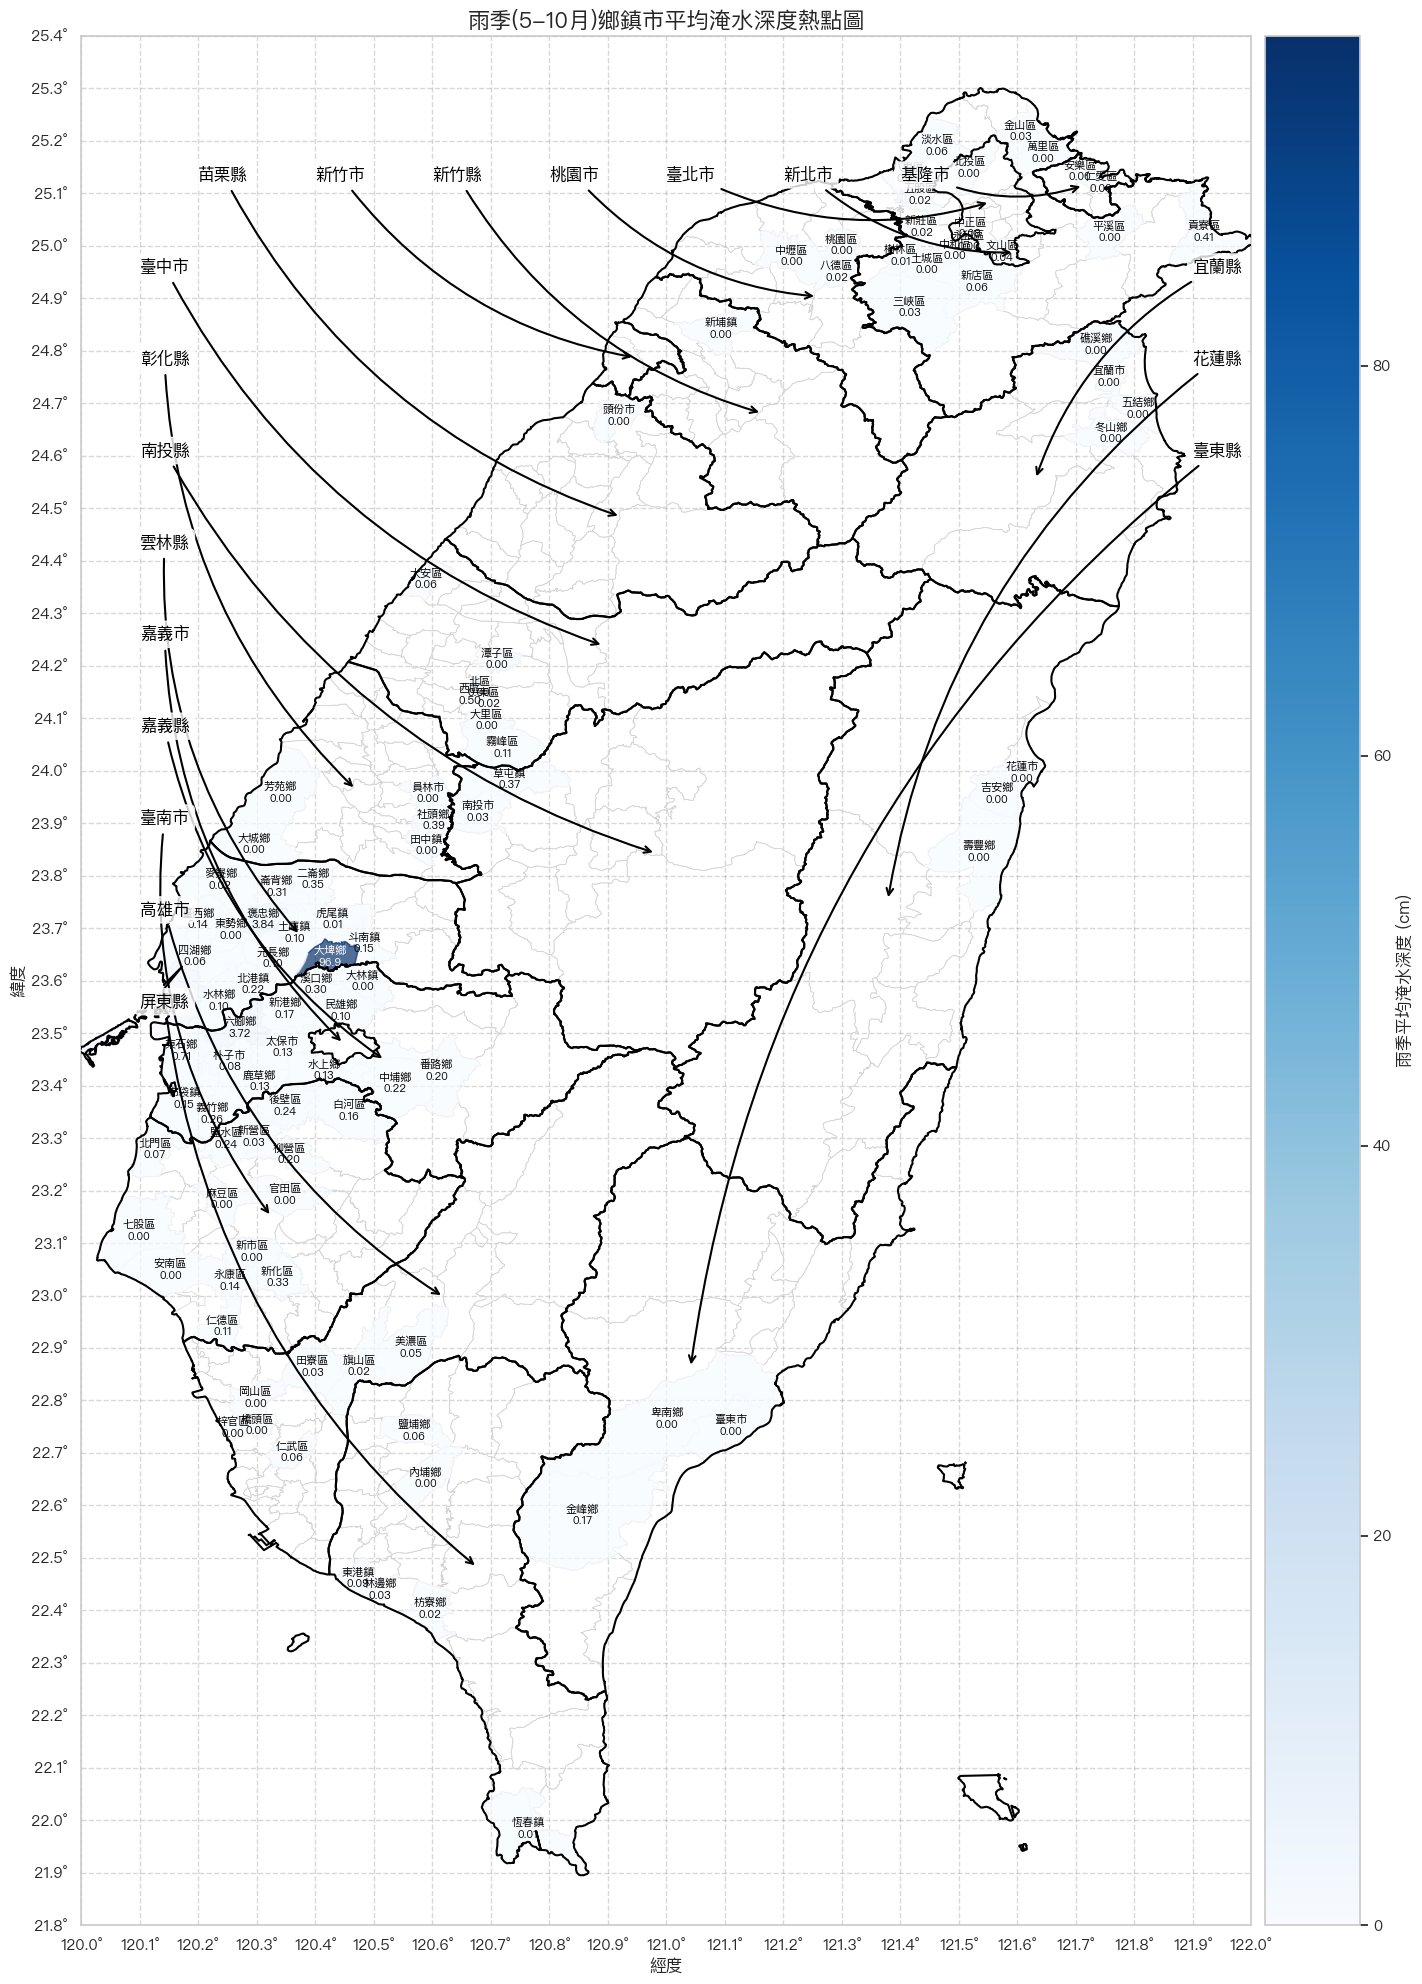

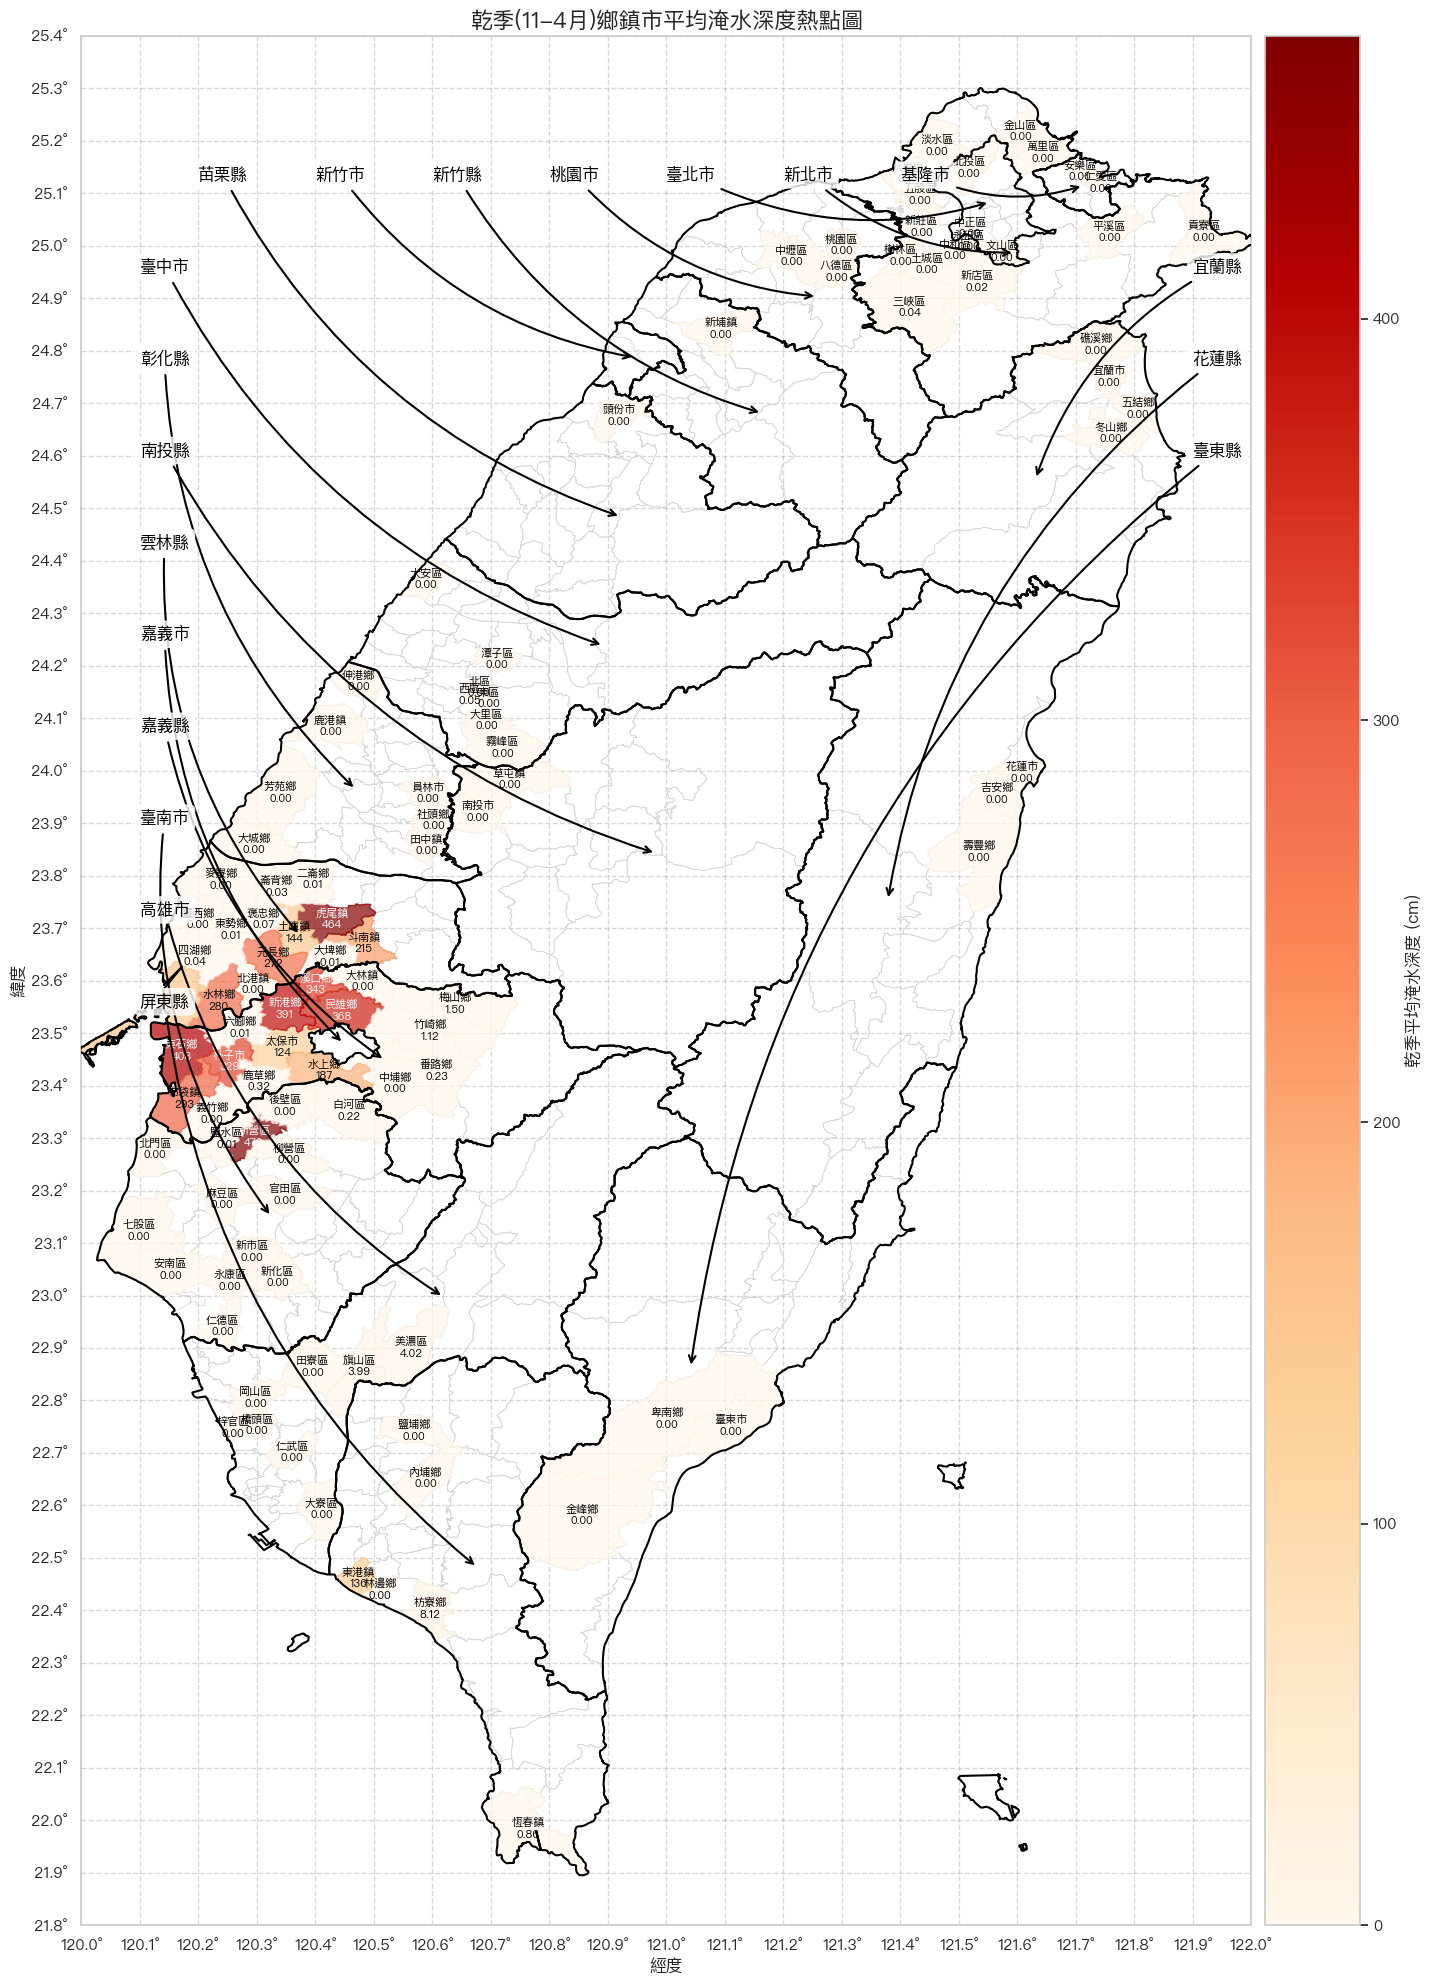

In [ ]:
# 設定路徑 (請更新為您的實際路徑)
shp_path = os.path.join(dataset_path,'鄉鎮市區界線(TWD97經緯度)/TOWN_MOI_1120317.shp')
sensor_data_path = os.path.join(dataset_path,'sensor' ,'flood_data_2019_merged_filled.csv')
output_dir = "output_maps"

# 創建輸出目錄
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. 讀取 shapefile
print("讀取地圖檔案...")
sf = load_shapefile(shp_path)

# 2. 讀取感測器資料
print("讀取淹水感測資料...")
# 範例資料格式:
# Unnamed: 0,station_id,file_date,value,PQ_fullname,Longitude,Latitude,TOWNNAME
sensor_df = pd.read_csv(sensor_data_path)

# 確保日期格式正確
sensor_df['file_date'] = pd.to_datetime(sensor_df['file_date'])

# 3. 計算每個鄉鎮市的統計資料
print("計算鄉鎮市統計資料...")
station_count_dict, avg_depth_dict = process_sensor_data(sensor_df)

# 5.4 分析雨季和乾季的差異
print("分析雨季和乾季的差異...")
# 雨季（5-10月）
rainy_season = sensor_df[(sensor_df['file_date'].dt.month >= 5) & 
                         (sensor_df['file_date'].dt.month <= 10)]
rainy_depth = rainy_season.groupby('TOWNNAME')['value'].mean().to_dict()

# 乾季（11-4月）
dry_season = sensor_df[~((sensor_df['file_date'].dt.month >= 5) & 
                       (sensor_df['file_date'].dt.month <= 10))]
dry_depth = dry_season.groupby('TOWNNAME')['value'].mean().to_dict()

# 繪製雨季淹水深度熱點圖
rainy_fig, rainy_ax = plot_township_heatmap(
    sf,
    rainy_depth,
    "雨季平均淹水深度 (cm)",
    cmap="Blues",
    figsize=(15, 20),
    title="雨季(5-10月)鄉鎮市平均淹水深度熱點圖",
    output_path=os.path.join(output_dir, "rainy_season_depth.png")
)

# 繪製乾季淹水深度熱點圖
dry_fig, dry_ax = plot_township_heatmap(
    sf,
    dry_depth,
    "乾季平均淹水深度 (cm)",
    cmap="OrRd",
    figsize=(15, 20),
    title="乾季(11-4月)鄉鎮市平均淹水深度熱點圖",
    output_path=os.path.join(output_dir, "dry_season_depth.png")
)

print("分析完成！所有地圖已儲存到", output_dir)